# Autoencoders and Generative Adversarial Networks - Part 1/3
### XX Seminar on Software for Nuclear, Subnuclear and Applied Physics, 4-9 June 2023, Hotel Porto Conte, Maristella SS, IT

Contacts: 
 * email: Lucio.Anderlini [at] fi.infn.it
 * GitHub: [github.com/landerlini](https://github.com/landerlini)
 
## Systems of Neural Networks

So far we discussed of several examples of Neural Networks for several different tasks, spanning from Regression and Classification to more fancy tasks such as Density Estimation or Clustering.
In general, to train a Neural Network we need to define a loss function and tune the weights of the neural network to minimize that loss.

In this lecture we will try to face the problem of more advanced tasks where the loss itself is defined by means of a Neural Network. In this case we are training simultaneously two neural networks with the ambition of using one to inform the other. 

We call this approach "Systems of Neural Networks" and we will see some examples trying to make connections with applications in High Energy Physics.


## Autoencoders
The first example we consider is the training of a neural network on a dataset without labels. 

Obtaining labels is in general much more complicated than obtaining data. You can easily dump the internet to get Petabytes of photos almost for free, but you need to pay someone to carefully label those photos if you want to use them in training. 

Still, you may use that large sample of images to let the network to learn "how to see", and then use a much smaller dataset of labeled data to teach the network "what it seeing".

Autoencoders are a type of artificial neural network that learn to compress and reconstruct data in an unsupervised manner. 
They consist of two parts: an **encoder** that transforms the input data into a lower-dimensional representation, and a **decoder** that recovers the original data from the representation.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf

Let's start with defining a helper function to display some digits and create the histogram of the gray values.

In [2]:
def rough_inspection(dataset, n_fig=4):
    """
    This function performs a rough inspection of a dataset of images by plotting some samples and a histogram of pixel values.

    Parameters
    ----------
    dataset : numpy array
        A numpy array of shape (N, 784) where N is the number of images and 784 is the number of pixels per image.
    n_fig : int, optional
        The number of images to plot per row. The default is 4.

    Returns
    -------
    None.
    """
    figure = np.concatenate([np.reshape(dataset[n_fig*i:n_fig*(i+1)], (n_fig*28, 28)) for i in range(n_fig)], axis=1)

    plt.figure(figsize=(7,2))
    plt.subplot(1, 2, 1)
    plt.imshow(figure, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.hist(dataset.flatten(), bins=50)
    plt.yscale('log')
    plt.xlabel("Pixel value")
    plt.show()
    


## Stratified sampling

Let's consider the situation where labeling data is very expensive. 
We have a large dataset of digits, but we can only afford labeling few of them, for example we decide to label eight examples per digit, using 4 samples for training and 4 for validation.

40

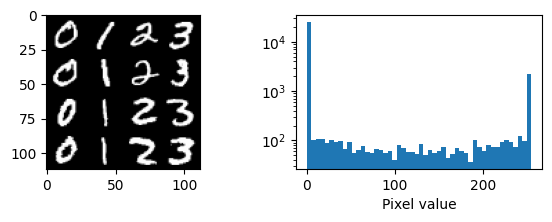

In [3]:
## Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Selects the first 4 indices for each digit from the training and test sets, respectively
train_idx = sum([np.arange(len(y_train))[y_train == i].tolist()[:4] for i in range(10)], [])
test_idx = sum([np.arange(len(y_test))[y_test == i].tolist()[:4] for i in range(10)], [])


Lx_train = x_train[train_idx]
Lx_test = x_test[test_idx]
Ly_train = y_train[train_idx]
Ly_test = y_test[test_idx]

display(len(Lx_train))
rough_inspection(Lx_train)

## Preprocessing

Preprocessing is an essential step to prepare image data for computer vision models, and in machine learning in general. 
One of the common preprocessing techniques is scaling, which is the process of mapping the gray values to a standard range, usually to the interval (0-1]).

Scaling can have several benefits for computer vision tasks, such as:
 * Reducing the computational cost and memory usage of training and inference, especially for large image;
 * Improving the performance and generalization of models by reducing the variance and noise in the input data;
 * Enhancing the features and details of images that are too small or blurry.
 
Packages such as `sckit-learn` provide tools for scaling, such as [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), here we decide to use plain numpy to limit black boxes.

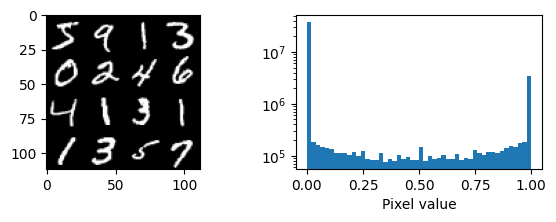

In [4]:
px_train = (x_train / x_train.max())
px_test = (x_test / x_train.max()) 
pLx_train = (Lx_train / x_train.max())
pLx_test = (Lx_test / x_train.max()) 

rough_inspection(px_train)

## Label preprocessing: *one-hot encoding*

For a human, the labels to be assigned to the digits will be 0, 1, 2... to 9. However, if using these labels in a machine-learning task the machine would assume that there is some kind of ordering, which implies that, for example, the digit 7 is more similar to the digit 8 than it is to digit 9.
This is clearly false.

To avoid any notion of order in the labeling, we use one-hot encoding, defining ten different boolean features. Among these, only one is one, while all of the others are zero. This is named one-hot encoding.

`scikit-learn` provides tools to encode and decode classes, such as [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). But here we take the opportunity to exercise our Python skills.

In [5]:
py_train = np.stack([Ly_train == i for i in range(10)], axis=1)
py_test = np.stack([Ly_test == i for i in range(10)], axis=1)

## A Dense classifier

To build an example of transfer learning let's start with a dense classifier made of several Dense layers, and let's try to train it on our 40 labeled examples of hand-written digits. The number of weights is rather high and, being a dense classifier, there are basically no assumptions on the *structure* of the input data.
As a consequence we do not expect great performance.

To limit the effect of overtraining we can introduce regularization terms, or simply stop the training rather soon.

> 🛑 ***Warning! Do not try this at home!*** Here, we are using a Dense classifier to classify images because we are trying to show an example of how "hypotheses" on the dataset can be learned from non-labeled samples and *transferred* to the classifier. For the purpose of the exercise we prefer short trainings and amplified effects. For no other reasons one would ever use a Dense classifier for images. **Use Convolutional Neural Networks instead!**


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 classifier (Dense)          (None, 10)                330       
                                                                 
Total params: 28,618
Trainable params: 28,618
Non-traina

2023-06-02 16:56:42.409674: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 16:56:42.428124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 16:56:42.429256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 16:56:42.431217: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

2/2 [==============================] - 1s 138ms/step - loss: 2.3204 - val_loss: 2.3347
Epoch 2/20
2/2 [==============================] - 0s 23ms/step - loss: 2.0941 - val_loss: 2.2539
Epoch 3/20
2/2 [==============================] - 0s 24ms/step - loss: 1.9372 - val_loss: 2.1844
Epoch 4/20
1/2 [==============>...............] - ETA: 0s - loss: 1.7895

2023-06-02 16:56:44.102407: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2/2 [==============================] - 0s 33ms/step - loss: 1.8076 - val_loss: 2.1200
Epoch 5/20
2/2 [==============================] - 0s 22ms/step - loss: 1.6810 - val_loss: 2.0608
Epoch 6/20
2/2 [==============================] - 0s 22ms/step - loss: 1.5682 - val_loss: 2.0072
Epoch 7/20
2/2 [==============================] - 0s 21ms/step - loss: 1.4708 - val_loss: 1.9580
Epoch 8/20
2/2 [==============================] - 0s 22ms/step - loss: 1.3869 - val_loss: 1.9111
Epoch 9/20
2/2 [==============================] - 0s 22ms/step - loss: 1.3052 - val_loss: 1.8635
Epoch 10/20
2/2 [==============================] - 0s 22ms/step - loss: 1.2265 - val_loss: 1.8188
Epoch 11/20
2/2 [==============================] - 0s 23ms/step - loss: 1.1529 - val_loss: 1.7799
Epoch 12/20
2/2 [==============================] - 0s 22ms/step - loss: 1.0898 - val_loss: 1.7470
Epoch 13/20
2/2 [==============================] - 0s 21ms/step - loss: 1.0305 - val_loss: 1.7154
Epoch 14/20
2/2 [====================

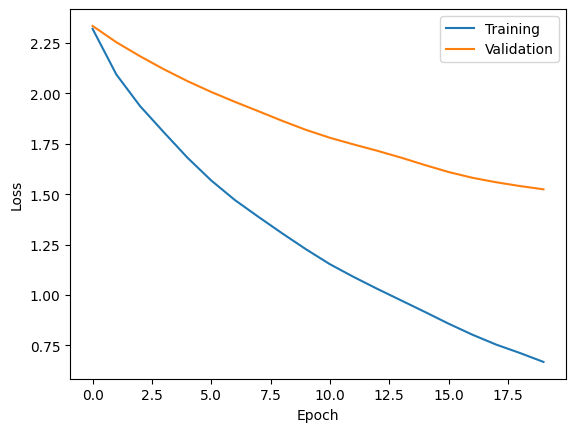

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
simple_classifier = Sequential([
    Flatten(),
    Dense(32, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(10, activation='softmax', name='classifier'),
])

simple_classifier.build(input_shape=(None, 28, 28))
simple_classifier.summary()

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
simple_classifier.compile(loss=CategoricalCrossentropy(), optimizer=Adam(1e-3))
history = simple_classifier.fit(pLx_train, py_train, validation_data=(pLx_test, py_test), epochs=20)

plt.plot(history.history['loss'], label="Training")
plt.plot(history.history['val_loss'], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The confusion matrix obtained from this classifier shows that the network is capable to distinguish some "simple" digits such as 1 or 0, but is not performing very well on most of the "more complicated" ones.

2/2 [==============================] - 0s 2ms/step


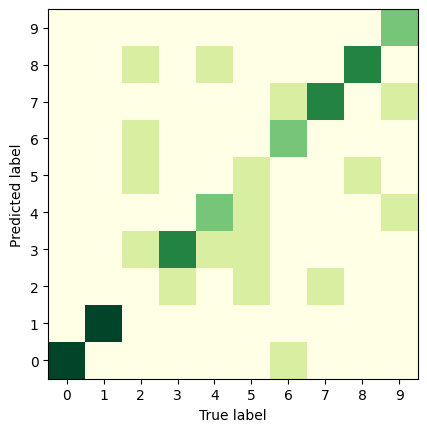

In [7]:
from sklearn.metrics import confusion_matrix
py_test_hat = np.argmax(simple_classifier.predict(pLx_test), axis=1)
plt.imshow(confusion_matrix(py_test_hat, Ly_test), origin='lower', cmap="YlGn")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.xticks(list(range(10)))
plt.yticks(list(range(10)))
plt.show()

## Let's use non-labeled examples to pre-train the classifier

So, let's take the layers our Dense classifier and copy-paste it into a new neural network, followed by a "decoder" which tries to map the outcome of the classification back into the image itself. 
To ease a bit the task, let's use two variables to encode the figure, instead of one single classifier.


🧐 This structure is named *Autoencoder*.

It is composed of an *encoder* (our Dense classifier) which compresses the information from the input to a ***latent space*** and a *decoder* that decodes the information in the latent space and translates it back into the original space.


Epoch 1/50


2023-06-02 16:56:46.338747: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800


235/235 [==============================] - 9s 29ms/step - loss: 0.2265 - val_loss: 0.1951
Epoch 2/50
235/235 [==============================] - 6s 24ms/step - loss: 0.1923 - val_loss: 0.1857
Epoch 3/50
235/235 [==============================] - 6s 24ms/step - loss: 0.1842 - val_loss: 0.1803
Epoch 4/50
235/235 [==============================] - 6s 24ms/step - loss: 0.1804 - val_loss: 0.1777
Epoch 5/50
235/235 [==============================] - 6s 24ms/step - loss: 0.1781 - val_loss: 0.1762
Epoch 6/50
235/235 [==============================] - 6s 24ms/step - loss: 0.1765 - val_loss: 0.1746
Epoch 7/50
235/235 [==============================] - 6s 24ms/step - loss: 0.1752 - val_loss: 0.1737
Epoch 8/50
235/235 [==============================] - 6s 24ms/step - loss: 0.1739 - val_loss: 0.1762
Epoch 9/50
235/235 [==============================] - 6s 24ms/step - loss: 0.1731 - val_loss: 0.1752
Epoch 10/50
235/235 [==============================] - 6s 24ms/step - loss: 0.1722 - val_loss: 0.1734


Text(0, 0.5, 'Loss')

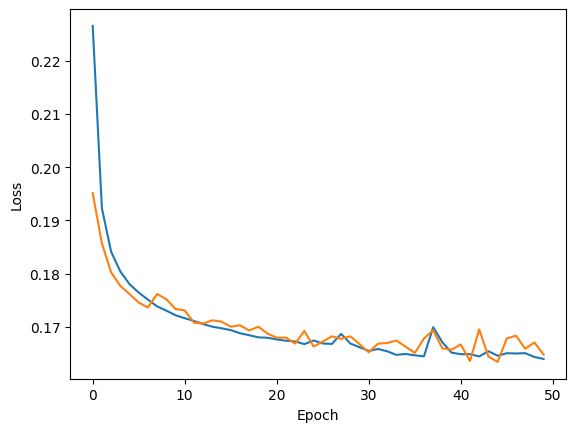

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.regularizers import L2
autoencoder = Sequential([
    Flatten(),                                                  #   /
    Dense(32, activation='tanh'),                               #  /
    Dense(32, activation='tanh'),                               # / ----- ENCODER
    Dense(32, activation='tanh'),                               # \ ----- Network
    Dense(32, activation='tanh', name='latent_repr_32'),        #  \
    Dense(2, activation='linear', name='latent_repr_2'),        #   \
    
    Dense(28//4*28//4, activation='tanh'),                      #
    Reshape((28//4, 28//4, 1)),                                 #
    Conv2DTranspose(32, 3, activation='relu'),                  #   /
    Conv2DTranspose(32, 3, activation='relu'),                  #  /
    UpSampling2D(size=(4,4)),                                   # / ----- DECODER
    Conv2DTranspose(8, 3, activation='relu'),                   # \ ----- Network
    Conv2DTranspose(8, 3, activation='relu'),                   #  \
    Flatten(),                                                  #   \
    Dense(28*28, activation='sigmoid'),                         #
    Reshape((28, 28))                                           #
])
autoencoder.build(input_shape=(None, 28, 28))

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
autoencoder.compile(loss=BinaryCrossentropy(), optimizer=Adam(3e-3))
history = autoencoder.fit(px_train, px_train, validation_data=(px_test[:128], px_test[:128]), epochs=50, batch_size=256)

plt.plot(history.history['loss'], label="Training data")
plt.plot(history.history['val_loss'], label="Validation data")
plt.xlabel("Epoch")
plt.ylabel("Loss")

Then we can show the reconstructed digits.
They are a bit fuzzy because it is easier for the autodecoder to make the border smoother than learning how to encode and decode small differences between different representations of the same figure, but the digits are perfectly readable.

313/313 [==============================] - 1s 3ms/step


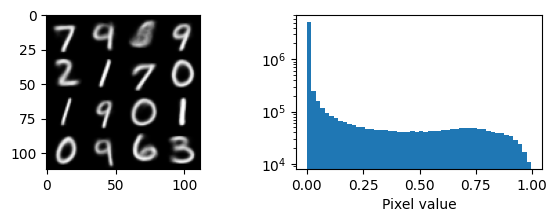

In [9]:
reconstructed = autoencoder.predict(px_test)
rough_inspection(reconstructed)

## A look to the latent space

Choosing a latent space of two variables we can easily plot the positions where the various digits are encoded.
The patterns of the latent space are often very interesting because they give hints on what the machine is learning, what is considered "similar" and what is considered "very different". 

For example, we see that the digit 1 is significantly separated from all of the other digits, with minor overlaps with some 3 and 5. This because the single segment representing the digit 1 is simple to identify, even for a simple neural network as the one we have defined.
Instead, the digits 5, 8 and 3 get mapped almost in a single cluster. A slight deformation of the the digit 3 may make it rather similar to a 5 and a rounded top of the digit 5 may be misinterpreted as the upper part of an 8.

Similarly, 9 and 7 are difficult to distinguish and some 4 (think to the 8-segment representation of a 4) is indeed similar to a 9. 

313/313 [==============================] - 0s 933us/step


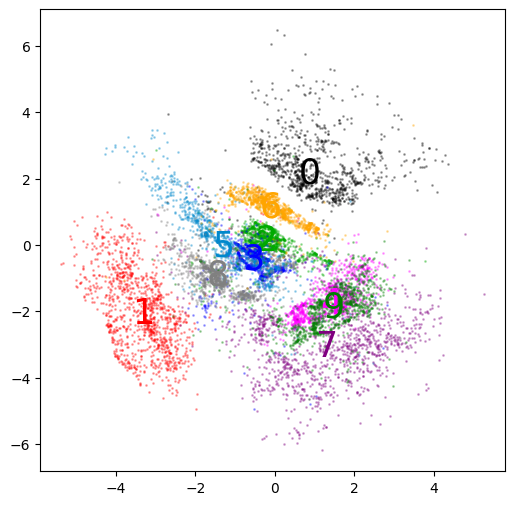

In [10]:
encoder = Sequential()
for layer in autoencoder.layers:
    layer.trainable = False
    encoder.add(layer)
    if 'latent_repr_2' in layer.name:
        break

encoded_test = encoder.predict(px_test)
u, v = encoded_test.T
plt.figure(figsize=(6,6))
colors = ['black', 'red', '#0a0', 'blue', 'magenta', '#08c', 'orange', 'purple', 'gray', 'green']
for digit, color in zip(range(10), colors):
    plt.plot(u[y_test == digit], v[y_test == digit], 'o', color=color, markersize=1, alpha=0.3)
    u_mean = np.quantile(u[y_test == digit], 0.5)
    v_mean = np.quantile(v[y_test == digit], 0.5)
    plt.text(u_mean, v_mean, f"{digit}", fontsize=25, alpha=1, color=color, ha='center', va='center')
plt.show()

## Transfer learning

Ok, let's get back to the original classification problem, with our 40 labels, 4 for each digit.

Now, we have trained a neural network that is capable of reproducing digits with a reasonable reconstruction error, using dense layers to encode the information in each figure into a 2-dimensional latent space. That seems quite powerful, maybe we can now use labels to identify the clusters, reusing the layers of the encoder to become part of a new classifier.

Let's do it!


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                25120     
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 latent_repr_32 (Dense)      (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 10)               

None

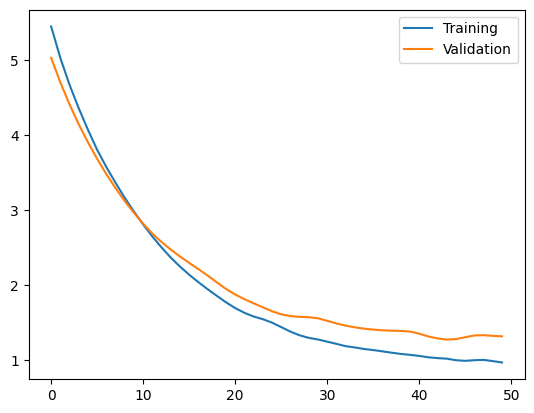

In [11]:
## We create a new sequential model
trans_classifier = Sequential()

## We copy the layers from the autoencoder to the new model, untill we reach the `latent_repr_32` layer. Then we stop.
for layer in autoencoder.layers:
    layer.trainable = False      ## These copied layers are frozen. We are not updating them as we trust the 
    trans_classifier.add(layer)  ##  training of the autoencoder will be adequate for the classification as well.
    if 'latent_repr_32' in layer.name:
        break

from tensorflow.keras.regularizers import L2
## We add another two layers, trainable this time.
trans_classifier.add(Dense(32, activation='tanh', kernel_regularizer=L2(1e-1)))
trans_classifier.add(Dense(10, activation='softmax'))

from tensorflow.keras.losses import CategoricalCrossentropy
trans_classifier.compile(loss=CategoricalCrossentropy(), optimizer=Adam(5e-3))

## And then we train our brand new classifier made up of trainable and inherited layers. 
## Notice: here, again, we are only allowed to exploit the 40 labels we have...
history = trans_classifier.fit(
    pLx_train, py_train, 
    validation_data=(pLx_test, py_test), epochs=50, verbose=False)

display(trans_classifier.summary())


plt.plot(history.history['loss'], label="Training")
plt.plot(history.history['val_loss'], label="Validation")

plt.legend()

The resulting confusion matrix should be a little bit better than the previous one, though digits with overlapping clusters remain difficult to classify...

> **Exercise.** One may try to improve the performance of both the autoencoder and classifier by relaxing the requirement on the dimensions of the latent space. Here we used 2 to make it visualizable, but you may increase the number of dimensions, reducing the compression factor and enhancing the information made available to the classifier.

2/2 [==============================] - 0s 3ms/step


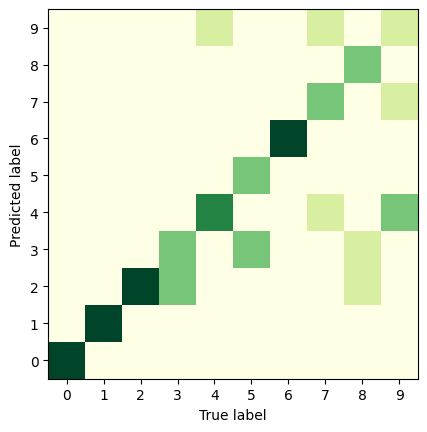

In [12]:
from sklearn.metrics import confusion_matrix
py_test_hat = np.argmax(trans_classifier.predict(pLx_test), axis=1)
plt.imshow(confusion_matrix(py_test_hat, Ly_test), origin='lower', cmap="YlGn")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.xticks(list(range(10)))
plt.yticks(list(range(10)))
plt.show()

# Anomaly detection

So far, we have trained a beautiful autoencoder that is capable of mapping into a 2-dimensional space the images of hand-written digits and then maps them back to the original image, with a **reconstruction error** minimized by the training of the Neural Networks. 

> **What happens if we evaluate the autoencoder with a hand-written letter instead of using a digit?**

Let's try. 
The `emnist` (Extended MNIST) dataset includes a set of hand-written digits and letters obtained from enveloppes and preprocessed for us.
We can access this larger dataset through the helper package `emnist` available on the Python Package Index (PyPI) which is the default repository of `pip`.

In [13]:
!conda run -p /envs/root pip install -q emnist
import emnist
letters, _ = emnist.extract_training_samples('letters')
digits, _ = emnist.extract_training_samples('digits')

letters = letters[:30000]/255
digits = digits[:30000]/255

Let's try to compare the quality of the reconstruction obtained with our autoencoder when running on the digit and letter datasets.

In [14]:
recoed_digits = autoencoder.predict(digits)
recoed_letters = autoencoder.predict(letters)

938/938 [==============================] - 2s 2ms/step


### Result on digits from EMNIST

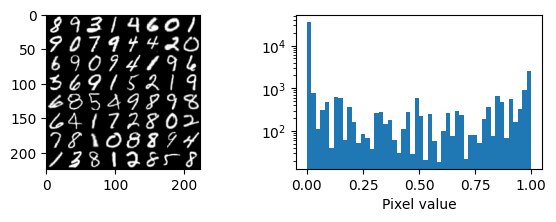

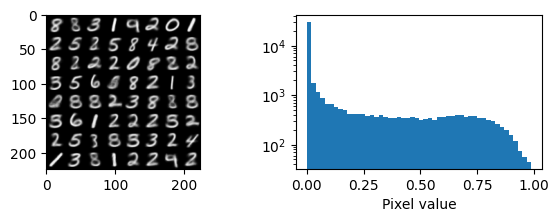

In [15]:
rough_inspection(digits[:64], n_fig=8)
rough_inspection(recoed_digits[:64], n_fig=8)

### Result on letters from EMNIST

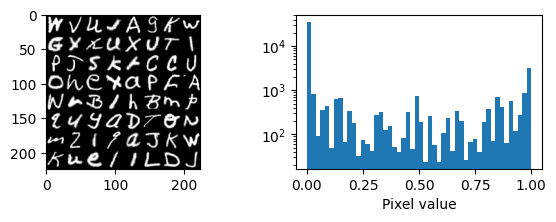

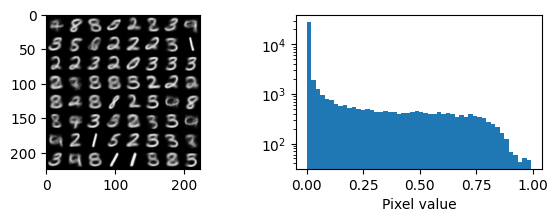

In [16]:
rough_inspection(letters[:64], n_fig=8)
rough_inspection(recoed_letters[:64], n_fig=8)

Our autoencoder has learned how to reconstruct digits and is now trying to reconstruct digits even when we provide a letter as an input.

This happens because the common features between digits have been memorized in the weights of the autoencoder to focus its attention of the differences between different digits and different examples of the same digit.

Hence, we expect the reconstruction error on letters to be larger than it is on digits.

This can be used to identify anomalies in the dataset, for example raising a warning when something that does not resemble to a digit gets provided to our system.

With a two-dimensional latent space and a Dense encoder, the reconstruction error is rather large also for the dgits, this makes it the performance of this autoencoder as an anomaly detector rather poor. 

Still, the reconstruction error on letters is, on average, larger than it is on digits, as shown in the following histogram.


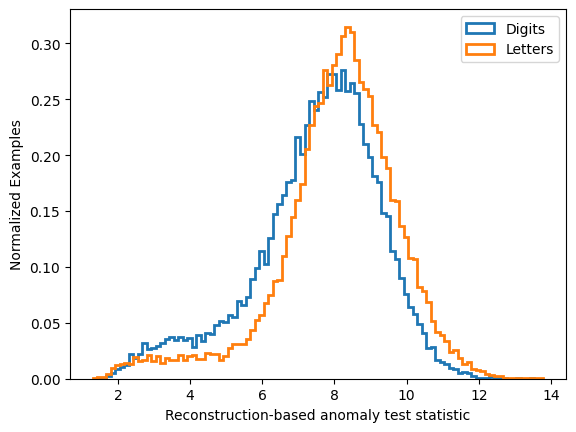

In [22]:
recoerr_digits = np.linalg.norm(recoed_digits - digits, axis=(1,2))
recoerr_letters = np.linalg.norm(recoed_letters - letters, axis=(1,2))
_, bins = np.histogram(np.concatenate((recoerr_digits, recoerr_letters)), bins=100)
plt.hist(recoerr_digits, bins=bins, label='Digits', histtype='step', linewidth=2, density=True)
plt.hist(recoerr_letters, bins=bins, label='Letters', histtype='step', linewidth=2, density=True)
plt.xlabel("Reconstruction-based anomaly test statistic") 
plt.ylabel("Normalized Examples")
plt.legend()
plt.show()

### Looking at the anomalies

If we pick the 64 most anomalous digits and the 64 most anomalous letters we observe that they are simply larger and thicker with respect to the average digit, and this makes the reconstruction error significantly larger than an additional or a missing trace changin a `9` into `P` or an `O` into `Q`.

Still, undeniably, it's finding anomalies.


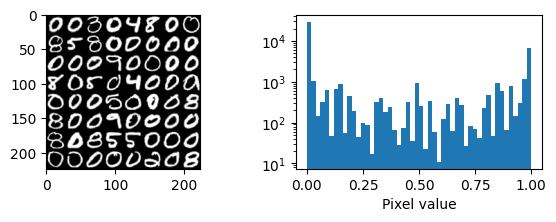

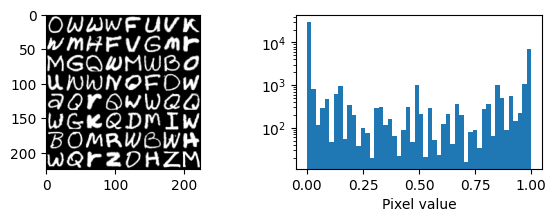

In [18]:
anomalous_digits = np.argsort(recoerr_digits)[-64:]
rough_inspection(digits[anomalous_digits], n_fig=8)

anomalous_letters = np.argsort(recoerr_letters)[-64:]
rough_inspection(letters[anomalous_letters], n_fig=8)

## Anomalies in the latent space
If we try to visualize where the anomalies are mapped encoded in our latent space, we see that they are filling regions at the boundaries between clusters of numbers. If we had a notion of density of points in the latent space, we might meybe better identify anomalies.

We'll discuss this in the next lecture.


938/938 [==============================] - 1s 891us/step


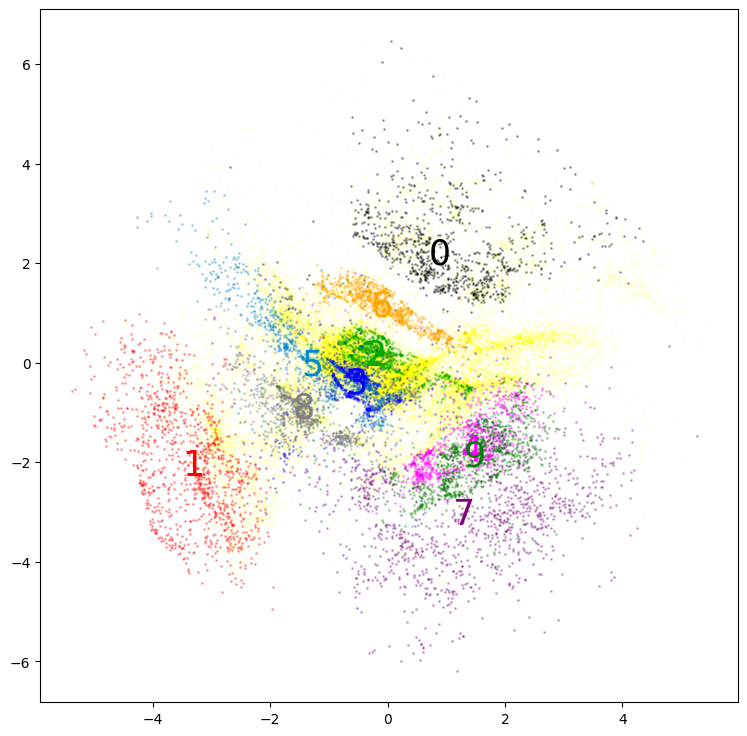

In [19]:
encoder = Sequential()
for layer in autoencoder.layers:
    layer.trainable = False
    encoder.add(layer)
    if 'latent_repr_2' in layer.name:
        break

encoded_test = encoder.predict(px_test)
encoded_letters = encoder.predict(letters)

u, v = encoded_test.T
plt.figure(figsize=(9,9))
colors = ['black', 'red', '#0a0', 'blue', 'magenta', '#08c', 'orange', 'purple', 'gray', 'green']
for digit, color in zip(range(10), colors):
    plt.plot(u[y_test == digit], v[y_test == digit], 'o', color=color, markersize=1, alpha=0.3)
    u_mean = np.quantile(u[y_test == digit], 0.5)
    v_mean = np.quantile(v[y_test == digit], 0.5)
    plt.text(u_mean, v_mean, f"{digit}", fontsize=25, alpha=1, color=color, ha='center', va='center')

u, v = encoded_letters.T
plt.plot(u, v, 'o', color="yellow", markersize=1, alpha=0.1, zorder=-100)

plt.show()

# Summary and link to INFN research lines

In this notebook we introduced the concept of Autoencoder as a Deep Neural Network composed of an *Encoder* and a *Decoder*.
We used this architecture to exploit non-labeled data to improve the classification performance of a classifier, by transferring the representations obtained from a *non-supervised* task into the classifier requiring labels. This approach is sometimes called **Transfer Learning** and has been used to create large pretrained models to process images (see [Keras applications](https://keras.io/api/applications/)) for a set of large pretrained models for computer vision. Some of these models is composed of hundreds of layers and most of them are trained on [14 milion images](https://www.image-net.org/).

Transfer learning is used in High Energy Physics when different tuning of models are needed to be applied in different conditions. When this happens, we often train a big model on as many data as possible, possibly merging datasets from different conditions, and then we fine-tune the model to specialize it to each set of conditions. This enables treating the correlations between various physical features with better accuracy and saving training time using pre-initialized neural networks. 

Anomaly detection is being explored to automate tasks of Data Quality Monitoring and Data Quality Validation to automate the identification of data taking runs with anomalous conditions of some detector, by spotting variations from the "normal" distributions, without defining a notion of anomaly (or an alternative hypothesis).

Autoencoders are sometimes used to define effective metrics for the status of some complex system, for example [measuring the disorder in a QCD lattice](https://arxiv.org/abs/2111.05216) to identify phase transitions.
